First try and run alpha shapes in batch

In [1]:
import numpy as np
from scipy.spatial import Delaunay
import math

In [2]:
import os
import numpy as np
import pandas as pd
import time
import skimage.io as io
io.use_plugin('tifffile')
import glob
from skimage import morphology
import mahotas as mh
from skimage.filters import threshold_adaptive
from scipy.ndimage import distance_transform_edt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import regionprops

from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

In [3]:
from descartes import PolygonPatch
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize
from matplotlib.collections import PolyCollection, transforms
from skimage.measure import grid_points_in_poly

In [4]:
from matplotlib.path import Path

In [5]:
from matplotlib.patches import Polygon

In [6]:
#load Hoechst and GFP stacks from .ome.tif files
def load_ome(ome_stack_file):

    #MMStack .ome.tif files load channel,z,y,x
    #Check file contains .ome.tif
    if '.ome.tif' in ome_stack_file:

        #Load the file
        im=io.imread(ome_stack_file)

        #Select Hoechst stack
        Hoechst_stack = im[0,:,:,:] #Hoechst Channel = 0
        GFP_stack = im[1,:,:,:]     #GFP Channel = 1
        
        #
        return [Hoechst_stack, GFP_stack]
        #return GFP_stack
        
    else:
        print 'this is not an ome.tif'

In [7]:
#[2] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/'

target='.ome.tif'

filelist=glob.glob(path+str('*')+target)

shell_list=glob.glob(path+str('/Output/Shells/*Split_Shells.npy'))

In [8]:
[Hoechst_stack, GFP_stack] = load_ome(filelist[4])

In [9]:
#[1] Get targeted filelist
path='C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/'

target='_Mask5.npy'

masklist=glob.glob(path+str('*')+target)

In [10]:
mask5 = np.load(masklist[1])

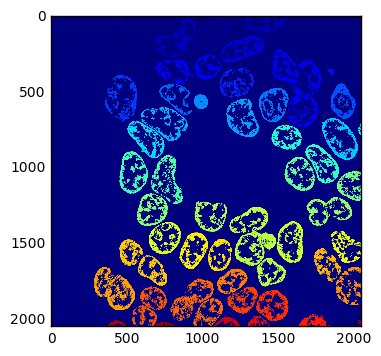

In [11]:
plt.imshow(mask5[8])

In [12]:
z=4
obj=6

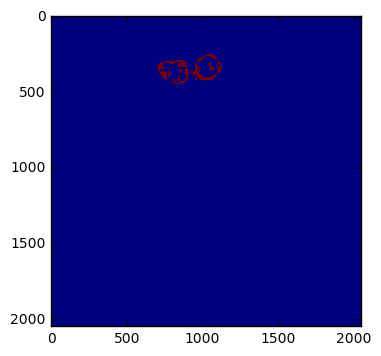

In [13]:
plt.imshow(mask5[z]==obj)

Functions

In [14]:
#[1]
def mask2points(binary_mask):
    
    points=np.transpose(np.nonzero(binary_mask))
    
    #print(len(points))

    #Return row, column coordinates converted to x, y
    return np.fliplr(points)

In [15]:
#[3]
def AlphaShape(points, triangles, alpha=0.25):
    
    edges = set()
    edge_points = []

    #print str(len(tri.vertices))+' triangles detected'
    
    #Not sure why, but this function must be embedded.
    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(points[ [i, j] ])
        #End of function

    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in triangles.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))

        if area>0:
            circum_r = a*b*c/(4.0*area)

            # Here's the radius filter.
            if circum_r < 1.0/alpha:
                add_edge(ia, ib)
                add_edge(ib, ic)
                add_edge(ic, ia)

    #print str(len(edge_points))+' edge points returned'    
    return edge_points

In [16]:
#[4] Convert points to boundary
# def edges2path(edge_points):
#     m = MultiLineString(edge_points)
#     triangles = list(polygonize(m))
#     polypath = (PolygonPatch(cascaded_union(triangles))).get_path()
#     return polypath

In [17]:
#[4] Convert points to boundary
def edges2path(edge_points):
    m = MultiLineString(edge_points)
    triangles = list(polygonize(m))
    
    #Convert triangles to polygon object
    boundary = cascaded_union(triangles)
    ptch = PolygonPatch(boundary)
    
    #Convert polygon path to a path
    polypath = ptch.get_path()
    return polypath

In [18]:
#[5] Path to Mask
def path2mask(stack, polypath):

    #Check shape of stack
    shape=stack.shape

    #flip x and y to r and c
    vert = np.fliplr(polypath.vertices)

    #Generate binary mask
    return grid_points_in_poly(shape, vert)

In [21]:
def getMask(labeled_stack, z, obj, alpha=0.25):
             
    points=[]
    triangles=[]
    edge_points=[]
    polypath=[]
    mask=np.zeros_like(labeled_stack[z])
        
    #[1] Convert mask row, column coordinates to x, y
    points = mask2points(labeled_stack[z]==obj)

    #[2] Triangluate
    triangles = Delaunay(points)

    #[3] Alpha Shape
    edge_points = AlphaShape(points, triangles, alpha)

    #[4] Convert triangles to polygon
    polypath = edges2path(edge_points)

    #[5] get polygon
    mask = path2mask(labeled_stack[z], polypath)*obj
                              
    return mask     

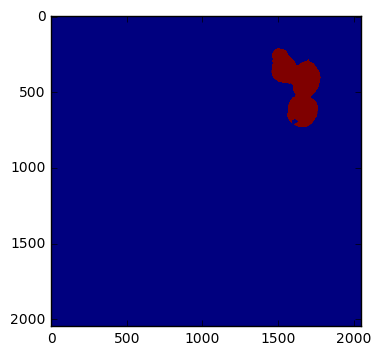

In [22]:
mask8 = getMask(mask5, z=4, obj=5, alpha=0.10)
plt.imshow(mask8)

Then try on 3D objects

In [69]:
##Does it work in 3D?
#[1] Convert mask to points
points=np.transpose(np.nonzero(mask5==6))
#points #z, r, c
#Sort points to z, x, y columns
new_order = [0,2,1]
i = np.argsort(new_order)
points = points[:,i]

In [70]:
#Much slower than 2D (13minutes for 506,144)
t0=time.time()
#Calculate tetrahedra
tetra = Delaunay(points)
t1=time.time()
print t1-t0

948.585000038


In [13]:
#How many points are there in the 3D mask?
len(points)

506144

In [ ]:
#Perhaps we can drop points by reducing the mask to its outline?


In [32]:
tri3D.vertices

array([[245775, 309201, 451032, 451033],
       [451034, 309201, 309200, 451032],
       [380284,  17135, 319142,  40786],
       ..., 
       [ 59906,  36860,  59728,  36687],
       [ 59906,  36860,  36859,  36687],
       [ 59906,  59907,  36860,  59728]])

In [34]:
tetra = tri3D.simplices

In [71]:
#Incredibly slow but successful method
tri3D=[]

for row in tetra.simplices:
    tri3D.append([row[0],row[1],row[2]])
    tri3D.append([row[0],row[1],row[3]])
    tri3D.append([row[0],row[2],row[3]])
    tri3D.append([row[1],row[2],row[3]])

tri3D = np.array(tri3D)

In [76]:
len(tri3D)

13683172

In [73]:
tri3D

array([[245775, 309201, 451032],
       [245775, 309201, 451033],
       [245775, 451032, 451033],
       ..., 
       [ 59906,  59907,  59728],
       [ 59906,  36860,  59728],
       [ 59907,  36860,  59728]])

In [80]:
def triprops(triangles):

    tps=[]
    
    #avoid loop
    for ia, ib, ic in triangles:
            pa = points[ia]
            pb = points[ib]
            pc = points[ic]

            # Absolute lengths of sides of triangle
            a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
            b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
            c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

            # Semiperimeter of triangle
            s = (a + b + c)/2.0

            # Area of triangle by Heron's formula
            squarea = s*(s-a)*(s-b)*(s-c)
            #area= math.sqrt(squarea)
            
            tps.append([a, b, c, s, squarea])    

    return tps

In [81]:
triangle_properties = triprops(tri3D)

In [77]:
triangle_properties

[[1.0, 1.0, 0.0, 1.0, 0.0]]

In [79]:
#Try alpha shape on 3D triangles
t0=time.time()
edge_points = AlphaShape2(points, tri3D, alpha=0.25)
t1=time.time()
print t1-t0

ValueError: math domain error

In [54]:
(Delaunay(mask2points(mask5[8]==6))).simplices

array([[19758, 19626, 20130],
       [11575, 11410, 12083],
       [19758, 19625, 19626],
       ..., 
       [ 1895,  1846,  1847],
       [ 1894,  1895,  1964],
       [ 1895,  1965,  1964]])

In [55]:
tri3D[1:4]

array([[245775, 309201, 451033],
       [245775, 451032, 451033],
       [309201, 451032, 451033]])

In [78]:
#[3]
def AlphaShape2(points, triangles, alpha=0.25):
    
    edges = set()
    edge_points = []

    #print str(len(tri.vertices))+' triangles detected'
    
    #Not sure why, but this function must be embedded.
    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(points[ [i, j] ])
        #End of function

    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in triangles:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        
        #provided no lengths = 0
        if (a >0 and b > 0 and c > 0):
    
            # Semiperimeter of triangle
            s = (a + b + c)/2.0

            # Area of triangle by Heron's formula
            area = math.sqrt(s*(s-a)*(s-b)*(s-c))

            if area>0:
                circum_r = a*b*c/(4.0*area)

                # Here's the radius filter.
                if circum_r < 1.0/alpha:
                    add_edge(ia, ib)
                    add_edge(ib, ic)
                    add_edge(ic, ia)

    #print str(len(edge_points))+' edge points returned'    
    return edge_points

In [ ]:
#[3]
def AlphaShape3D(points, tetrahedra, alpha=0.25):
    
    edges = set()
    edge_points = []

    #print str(len(tri.vertices))+' triangles detected'
    
    #Not sure why, but this function must be embedded.
    def add_edge(i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(points[ [i, j] ])
        #End of function

    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic, ie in tetrahedra.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        pe = points[ie]

        # Lengths of sides of tetrahedra (need a lot more rows)
        ab = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        ac = math.sqrt((pa[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        ae = math.sqrt((pa[0]-pe[0])**2 + (pc[1]-pa[1])**2)
        bc = math.sqrt((pb[0]-pc[0])**2 + (pc[1]-pa[1])**2)
        be = math.sqrt((pb[0]-pe[0])**2 + (pc[1]-pa[1])**2)
        ce = math.sqrt((pc[0]-pe[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))

        if area>0:
            circum_r = a*b*c/(4.0*area)

            # Here's the radius filter.
            if circum_r < 1.0/alpha:
                add_edge(ia, ib)
                add_edge(ib, ic)
                add_edge(ic, ia)

    #print str(len(edge_points))+' edge points returned'    
    return edge_points